In [219]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import os

In [220]:
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
batch_size = 16
lr = 3e-4
n_epochs = 25

1. 資料前處理過程

In [221]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [222]:
train_set = datasets.ImageFolder(root="train", transform=test_transform)
valid_set = datasets.ImageFolder(root="train", transform=test_transform)
print("length of train set:", len(train_set))
print(train_set.class_to_idx)

length of train set: 9866
{'trainingdata0': 0, 'trainingdata1': 1, 'trainingdata10': 2, 'trainingdata2': 3, 'trainingdata3': 4, 'trainingdata4': 5, 'trainingdata5': 6, 'trainingdata6': 7, 'trainingdata7': 8, 'trainingdata8': 9, 'trainingdata9': 10}


In [223]:
def get_train_valid_dataloaders(train_set, valid_set, split_ratio, batch_size, shuffle=True, num_workers=2):
    
    idx = list(range(len(train_set)))
    
    if shuffle:
        np.random.shuffle(idx)
        
    split = int(np.floor(split_ratio * len(train_set)))
    
    train_idx, valid_idx = idx[split:], idx[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
    
    return train_loader, valid_loader

In [224]:
train_loader, valid_loader = get_train_valid_dataloaders(train_set, train_set, 0.2, batch_size=batch_size)

2. 自行設計的模型架構

In [225]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [226]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 11):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
                        
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
#                         nn.BatchNorm2d(64),
#                         nn.ReLU())
#         self.maxpool = nn.Identity()
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        # self.fc = nn.Sequential(
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, num_classes)
        # )
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [227]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [228]:
def train(model, train_loader, device, optimizer, loss_fn, epoch, scheduler=None):
    model.train()
    train_loss = 0.
    n_corrects = 0
    total = 0

    # Use tqdm for a progress bar
    from tqdm import tqdm
    pbar = tqdm(train_loader, desc="Training")

    for idx, (images, labels) in enumerate(pbar):
    # for idx,(images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()  
        loss.backward()
        
        optimizer.step()
        
        
        # Calculate accuracy
        _, predictions = torch.max(outputs, dim=1)
        batch_correct = predictions.eq(labels).sum().item()
        batch_size = labels.size(0)
        
        # Update metrics
        n_corrects += batch_correct
        total += batch_size
        train_loss += loss.item() * batch_size
        
        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            'epoch': epoch,
            'loss': f"{train_loss/total:.4f}",
            'acc': f"{100.*n_corrects/total:.2f}%",
            'lr': f"{current_lr:.6f}"
        })
    
    # Step the scheduler if it's epoch-based
    if scheduler is not None and not hasattr(scheduler, 'step_batch'):
        scheduler.step()
    
    # Calculate final metrics
    avg_loss = train_loss / total
    accuracy = n_corrects / total
    
    return avg_loss, accuracy

In [229]:
@torch.no_grad()
def validate(model, valid_loader, device, loss_fn, epoch):
    """
    Validate the model on the validation dataset.
    
    Args:
        model: The neural network model
        valid_loader: DataLoader for validation data
        device: Device to run validation on (cuda/cpu)
        loss_fn: Loss function
        epoch: Current epoch number
    Returns:
        tuple: (validation_loss, validation_accuracy)
    """
    model.eval()
    valid_loss = 0.
    n_corrects = 0
    total = 0
    
    # Use tqdm for a progress bar
    from tqdm import tqdm
    pbar = tqdm(valid_loader, desc="Validation")
    
    for images, labels in pbar:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = loss_fn(outputs, labels)
        
        # Calculate accuracy
        _, predictions = torch.max(outputs, dim=1)
        batch_correct = predictions.eq(labels).sum().item()
        batch_size = labels.size(0)
        
        # Update metrics
        n_corrects += batch_correct
        total += batch_size
        valid_loss += loss.item() * batch_size
        
        # Update progress bar
        pbar.set_postfix({
            'epoch': epoch,
            'loss': f"{valid_loss/total:.4f}",
            'acc': f"{100.*n_corrects/total:.2f}%"
        })
    
    # Calculate final metrics
    avg_loss = valid_loss / total
    accuracy = n_corrects / total
    
    print(f"Validation: Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} ({n_corrects}/{total})")
    
    return avg_loss, accuracy

3. 模型訓練過程與變化

In [230]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=lr, 
    weight_decay=5e-4
    )

loss_fn = nn.CrossEntropyLoss()

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(model, train_loader, device, optimizer, loss_fn, epoch)
    valid_loss, valid_accuracy = validate(model, valid_loader, device, loss_fn, epoch)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(training_accuracy)
    valid_acc_list.append(valid_accuracy)

    scheduler.step(valid_loss)

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy}")

Validation: 100%|██████████| 124/124 [00:04<00:00, 30.38it/s, epoch=1, loss=2.0184, acc=28.43%]


Validation: Loss: 2.0184 | Accuracy: 0.2843 (561/1973)
Epoch 1/25: training accuracy: 0.29583174965159004, valid accuracy: 0.2843385707045109


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.35it/s, epoch=2, loss=1.7942, acc=38.82%]


Validation: Loss: 1.7942 | Accuracy: 0.3882 (766/1973)
Epoch 2/25: training accuracy: 0.36513366273913594, valid accuracy: 0.3882412569690826


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.16it/s, epoch=3, loss=1.7697, acc=38.57%]


Validation: Loss: 1.7697 | Accuracy: 0.3857 (761/1973)
Epoch 3/25: training accuracy: 0.416698340301533, valid accuracy: 0.38570704510897114


Validation: 100%|██████████| 124/124 [00:04<00:00, 28.60it/s, epoch=4, loss=1.5977, acc=44.86%]


Validation: Loss: 1.5977 | Accuracy: 0.4486 (885/1973)
Epoch 4/25: training accuracy: 0.4536931458254149, valid accuracy: 0.4485554992397364


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.46it/s, epoch=5, loss=1.4745, acc=50.38%]


Validation: Loss: 1.4745 | Accuracy: 0.5038 (994/1973)
Epoch 5/25: training accuracy: 0.49613581654630684, valid accuracy: 0.5038013177901672


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.54it/s, epoch=6, loss=1.4689, acc=51.50%]


Validation: Loss: 1.4689 | Accuracy: 0.5150 (1016/1973)
Epoch 6/25: training accuracy: 0.5209679462815152, valid accuracy: 0.5149518499746579


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.39it/s, epoch=7, loss=1.3854, acc=52.31%]


Validation: Loss: 1.3854 | Accuracy: 0.5231 (1032/1973)
Epoch 7/25: training accuracy: 0.5359179019384265, valid accuracy: 0.5230613279270147


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.58it/s, epoch=8, loss=1.3510, acc=54.13%]


Validation: Loss: 1.3510 | Accuracy: 0.5413 (1068/1973)
Epoch 8/25: training accuracy: 0.5635373115418726, valid accuracy: 0.5413076533198176


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.37it/s, epoch=9, loss=1.3968, acc=52.20%]


Validation: Loss: 1.3968 | Accuracy: 0.5220 (1030/1973)
Epoch 9/25: training accuracy: 0.5792474344355758, valid accuracy: 0.5220476431829701


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.13it/s, epoch=10, loss=1.5447, acc=50.84%]


Validation: Loss: 1.5447 | Accuracy: 0.5084 (1003/1973)
Epoch 10/25: training accuracy: 0.5938173064740909, valid accuracy: 0.508362899138368


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.60it/s, epoch=11, loss=1.2685, acc=56.92%]


Validation: Loss: 1.2685 | Accuracy: 0.5692 (1123/1973)
Epoch 11/25: training accuracy: 0.6180159635119726, valid accuracy: 0.5691839837810441


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.35it/s, epoch=12, loss=1.2605, acc=59.45%]


Validation: Loss: 1.2605 | Accuracy: 0.5945 (1173/1973)
Epoch 12/25: training accuracy: 0.6346129481819334, valid accuracy: 0.5945261023821592


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.01it/s, epoch=13, loss=1.3052, acc=57.12%]


Validation: Loss: 1.3052 | Accuracy: 0.5712 (1127/1973)
Epoch 13/25: training accuracy: 0.6519701000886862, valid accuracy: 0.5712113532691333


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.11it/s, epoch=14, loss=1.1543, acc=60.92%]


Validation: Loss: 1.1543 | Accuracy: 0.6092 (1202/1973)
Epoch 14/25: training accuracy: 0.6612188014696566, valid accuracy: 0.6092245311708059


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.26it/s, epoch=15, loss=1.1182, acc=61.78%]


Validation: Loss: 1.1182 | Accuracy: 0.6178 (1219/1973)
Epoch 15/25: training accuracy: 0.6952996325858356, valid accuracy: 0.617840851495185


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.70it/s, epoch=16, loss=1.6907, acc=51.50%]


Validation: Loss: 1.6907 | Accuracy: 0.5150 (1016/1973)
Epoch 16/25: training accuracy: 0.7212720131762321, valid accuracy: 0.5149518499746579


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.05it/s, epoch=17, loss=1.3558, acc=57.68%]


Validation: Loss: 1.3558 | Accuracy: 0.5768 (1138/1973)
Epoch 17/25: training accuracy: 0.7462308374509059, valid accuracy: 0.5767866193613786


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.53it/s, epoch=18, loss=1.2370, acc=60.26%]


Validation: Loss: 1.2370 | Accuracy: 0.6026 (1189/1973)
Epoch 18/25: training accuracy: 0.7747371088306094, valid accuracy: 0.6026355803345159


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.46it/s, epoch=19, loss=0.9482, acc=69.89%]


Validation: Loss: 0.9482 | Accuracy: 0.6989 (1379/1973)
Epoch 19/25: training accuracy: 0.8966172557962752, valid accuracy: 0.6989356310187532


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.12it/s, epoch=20, loss=0.9691, acc=69.94%]


Validation: Loss: 0.9691 | Accuracy: 0.6994 (1380/1973)
Epoch 20/25: training accuracy: 0.9314582541492462, valid accuracy: 0.6994424733907755


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.28it/s, epoch=21, loss=0.9843, acc=69.39%]


Validation: Loss: 0.9843 | Accuracy: 0.6939 (1369/1973)
Epoch 21/25: training accuracy: 0.9478018497402761, valid accuracy: 0.6938672072985301


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.38it/s, epoch=22, loss=1.0117, acc=68.78%]


Validation: Loss: 1.0117 | Accuracy: 0.6878 (1357/1973)
Epoch 22/25: training accuracy: 0.9569238565817814, valid accuracy: 0.6877850988342625


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.28it/s, epoch=23, loss=0.9985, acc=69.23%]


Validation: Loss: 0.9985 | Accuracy: 0.6923 (1366/1973)
Epoch 23/25: training accuracy: 0.975674648422653, valid accuracy: 0.6923466801824633


Validation: 100%|██████████| 124/124 [00:04<00:00, 30.01it/s, epoch=24, loss=1.0168, acc=68.32%]


Validation: Loss: 1.0168 | Accuracy: 0.6832 (1348/1973)
Epoch 24/25: training accuracy: 0.9747877866463955, valid accuracy: 0.6832235174860618


Validation: 100%|██████████| 124/124 [00:04<00:00, 29.08it/s, epoch=25, loss=1.0127, acc=69.23%]

Validation: Loss: 1.0127 | Accuracy: 0.6923 (1366/1973)
Epoch 25/25: training accuracy: 0.9763081211199798, valid accuracy: 0.6923466801824633


----- LOSS 變化圖 -----

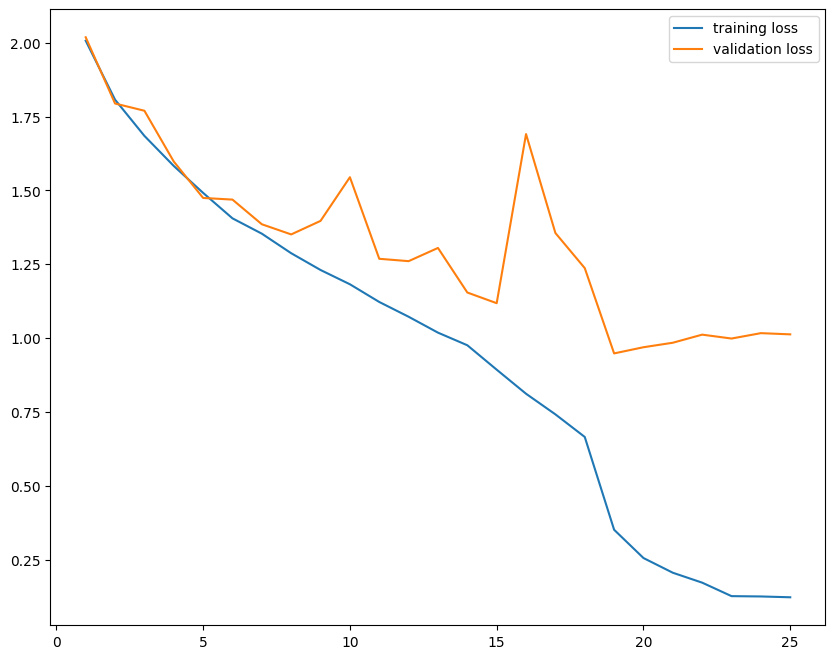

In [231]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

----- ACCURACY 變化圖 -----

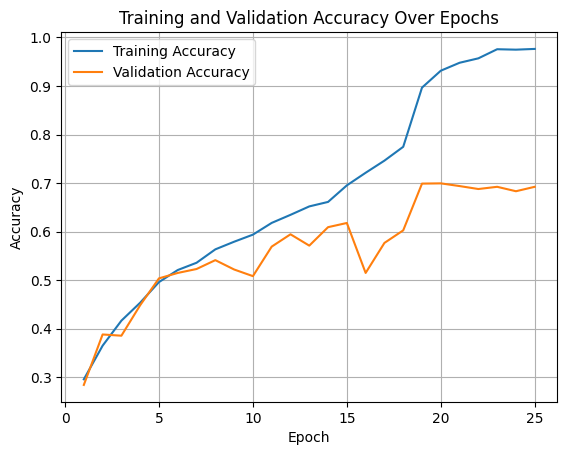

In [232]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, n_epochs+1), valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [233]:
model.eval()

test_folder = 'testingdata'
image_paths = sorted([
    os.path.join(test_folder, fname)
    for fname in os.listdir(test_folder)
    if fname.endswith(".jpg")
], key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

results = []

for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    input_tensor = test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()
    
    if predicted_class == 2:
        predicted_class = 10
    elif 3 <= predicted_class <= 10:
        predicted_class -= 1

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    results.append({'Index': image_name, 'Label': predicted_class})

    print(f"{image_name} -> Predicted class: {predicted_class}")

df = pd.DataFrame(results)
df.to_csv("predictions.csv", index=False)
print("results are stored in predictions.csv !")

0 -> Predicted class: 3
1 -> Predicted class: 8
2 -> Predicted class: 4
3 -> Predicted class: 10
4 -> Predicted class: 6
5 -> Predicted class: 4
6 -> Predicted class: 3
7 -> Predicted class: 2
8 -> Predicted class: 4
9 -> Predicted class: 3
10 -> Predicted class: 3
11 -> Predicted class: 9
12 -> Predicted class: 10
13 -> Predicted class: 0
14 -> Predicted class: 9
15 -> Predicted class: 0
16 -> Predicted class: 1
17 -> Predicted class: 3
18 -> Predicted class: 0
19 -> Predicted class: 5
20 -> Predicted class: 7
21 -> Predicted class: 0
22 -> Predicted class: 8
23 -> Predicted class: 4
24 -> Predicted class: 0
25 -> Predicted class: 2
26 -> Predicted class: 9
27 -> Predicted class: 10
28 -> Predicted class: 3
29 -> Predicted class: 3
30 -> Predicted class: 5
31 -> Predicted class: 0
32 -> Predicted class: 0
33 -> Predicted class: 6
34 -> Predicted class: 10
35 -> Predicted class: 1
36 -> Predicted class: 3
37 -> Predicted class: 7
38 -> Predicted class: 5
39 -> Predicted class: 4
40 -> 